##### Code 1. Attempt (Fail)
---------------------------------------------------------------------
// Load the image
var Hydro = ee.Image("MERIT/Hydro/v1_0_1");
// Load Shapefile
var region = ee.FeatureCollection('projects/ee-chymyak/assets/ArcticGRO_Yenisei_watershed');
// Clip the image to the shapefile boundary
var ClippedHydro = Hydro.clip(region);
// Export the clipped data to Google Drive
Export.image.toDrive({
  image: ClippedHydro,
  description: 'MERIT_Hydro_Global_Hydrography_Datasets',
  folder: 'MERIT_Hydro_Yenisey',
  maxPixels: 1e13,
  region: region.geometry(),
  crs: 'EPSG:4326'
});
---------------------------------------------------------------------

##### Error

Error: Exported bands must have compatible data types; found inconsistent types: Float32 and Byte. (Error code: 3)

---------------------------------------------------------------------

#### Solution:

Import one band (River Width)

---------------------------------------------------------------------
##### Code 2. Success
// Load the MERIT Hydro dataset
var Hydro = ee.Image("MERIT/Hydro/v1_0_1");

// Load your region of interest
var region = ee.FeatureCollection('projects/ee-chymyak/assets/ArcticGRO_Yenisei_watershed');

// Select only the River Width band
var riverWidth = Hydro.select('wth');

// Clip the River Width band to your region
var clippedRiverWidth = riverWidth.clip(region);

// Export the clipped River Width band to Google Drive
Export.image.toDrive({
  image: clippedRiverWidth,
  description: 'MERIT_Hydro_River_Width_Yenisey',
  folder: 'MERIT_Hydro_Yenisey',
  maxPixels: 1e13,
  region: region.geometry(),
  crs: 'EPSG:4326'
});
---------------------------------------------------------------------

In [1]:
import os                       # interacting with the operating system
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis
import geopandas as gpd         # working with geospatial data
import rasterio                       # core library
from rasterio.plot import show        # for displaying raster images

import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
from matplotlib.colors import Normalize, LogNorm

# Define Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')
# Yenisey Watershed (Shapefile)
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes (Shapefile)
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

# River Width (MERIT_Hydro)
hydro = 'MERIT_Hydro_River_Width_Yenisey.tif'

In [2]:
# Check it out
with rasterio.open(hydro) as src:
    meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 3440,
 'height': 2812,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008983152841195215, 0.0, 83.98349591233406,
        0.0, -0.008983152841195215, 71.63166075569065)}

Number of Unique Values: 133539
Mean: 426.5
Median: 78.1
Range: (0.4 - 53433.3)
1st Percentile: 8.10
99th Percentile: 5373.45


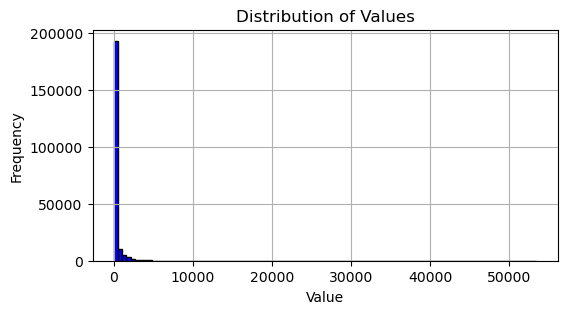

In [3]:
with rasterio.open(hydro) as src:
    # Read the data and mask out the NoData values
    data = src.read(1, masked=True)

# Ensure that data is a numpy masked array to handle NoData values correctly
if not np.ma.is_masked(data):
    data = np.ma.masked_array(data, np.isnan(data))

# Calculate statistics on the data array
# Using masked array ensures NoData values are ignored in calculations
unique_values = np.ma.unique(data)
mean_value = np.ma.mean(data)
median_value = np.ma.median(data)
min_value = np.ma.min(data)
min_value = min_value.data if np.ma.is_masked(min_value) else min_value
max_value = np.ma.max(data)
max_value = max_value.data if np.ma.is_masked(max_value) else max_value

print(f'Number of Unique Values: {len(unique_values)}')
print(f'Mean: {mean_value:.1f}')
print(f'Median: {median_value:.1f}')
print(f'Range: ({min_value:.1f} - {max_value:.1f})')

# Compute the 2nd and 98th percentiles
# Using compressed to get only non-masked data
p1, p99 = np.percentile(data.compressed(), [1, 99])
print(f'1st Percentile: {p1:.2f}')
print(f'99th Percentile: {p99:.2f}')

plt.figure(figsize=(6, 3))
plt.hist(data.ravel(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

### Note:

- Had to use a log-scale to visualize the dataset
- from matplotlib.colors import Normalize, LogNorm

In [4]:
with rasterio.open(hydro) as src:
    data = src.read(1)
    data[data == src.nodata] = np.nan  # Handle NoData values

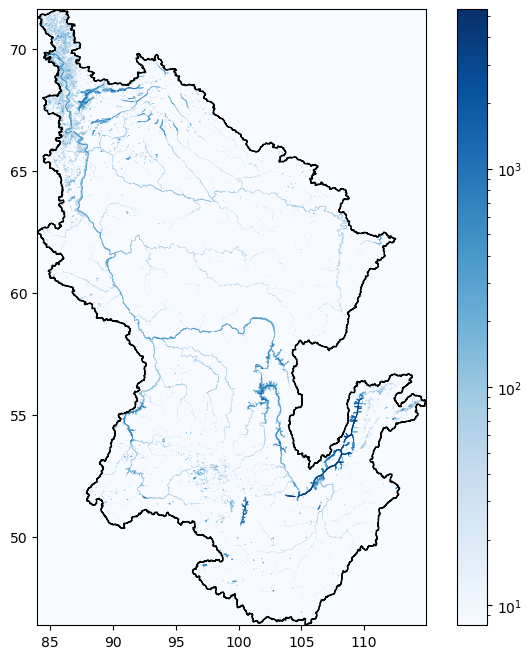

In [5]:
# Normalize the colormap based on percentiles
norm = Normalize()  # 2nd to 98th percentile

# Replace zeros with small non-zero value for log scale
data_log = np.where(data > 0, data, 1e-6)
norm_log = LogNorm(vmin=p1, vmax=p99)

fig, ax = plt.subplots(figsize=(8, 8))
# Raster Data
img = ax.imshow(data_log, cmap='Blues', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top], norm=norm_log)
# Vector Data
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1)
plt.colorbar(img, ax=ax)
plt.show()

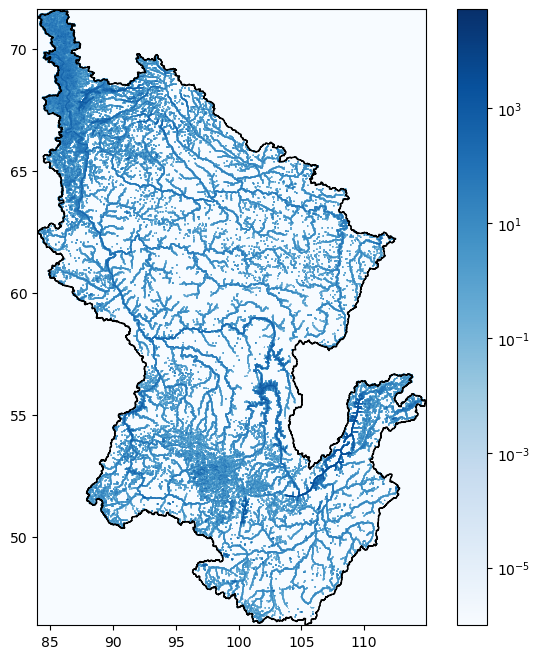

In [6]:
# Normalize the colormap based on percentiles
norm = Normalize(vmin=p1, vmax=p99)  # 2nd to 98th percentile

# Replace zeros with small non-zero value for log scale
data_log = np.where(data > 0, data, 1e-6)
norm_log = LogNorm()

fig, ax = plt.subplots(figsize=(8, 8))
# Raster Data
img = ax.imshow(data_log, cmap='Blues', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top], norm=norm_log)
# Vector Data
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1)
plt.colorbar(img, ax=ax)
plt.show()

# Isolate Points of Interest
- Using datasets containing latitude and longitude from surface waters in the Main River Channel of this area,find the river width associated with each sample site, and add it as a column in the dataframe containing environmental samples. 

In [7]:
# Load the river width raster
#with rasterio.open(hydro) as src:
#    affine = src.transform
#    river_width_array = src.read(1)
#    river_width_array[river_width_array == src.nodata] = np.nan  # Handle NoData values

# Function to get river width at a given location
#def get_river_width(lat, lon, src, array):
#    row, col = src.index(lon, lat)
#    return array[row, col]

# Apply the function to each row in the Water Data
#water['River_Width'] = water.apply(lambda row: get_river_width(row['lat_w'], 
#                                                               row['lon_w'], 
#                                                               src, river_width_array), axis=1)

# Apply the function to each row in the Air Data
#air['River_Width'] = air.apply(lambda row: get_river_width(row['lat_a'], 
#                                                           row['lon_a'], 
#                                                           src, river_width_array), axis=1)

# Save Files
#water.to_csv('chomiak_yenisey_water_clean_rw.csv')
#air.to_csv('chomiak_yenisey_air_clean_rw.csv')

# Folder
#os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')

In [8]:
# Folder
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')

# Import Water Data (Amon_2016_Yenisei)
waterfile = 'chomiak_yenisey_water_clean_rw.csv'
water = pd.read_csv(waterfile, parse_dates=[0])
water.columns = water.columns.str.strip()

# Import Air Data (Amon_2016_Yenisei)
airfile = 'chomiak_yenisey_air_clean_rw.csv'
air = pd.read_csv(airfile,  parse_dates=[0])
air.columns = air.columns.str.strip()

# Rename latitude column
water = water.rename(columns={'lat_w': 'lat'})
air = air.rename(columns={'lat_a': 'lat'})

# Rename RW column
water = water.rename(columns={'River_Width_w': 'River_Width'})
air = air.rename(columns={'River_Width_a': 'River_Width'})

# Combine
combined_df = pd.concat([water,air])
# Sort
combined_df = combined_df.sort_values(by='lat')

# Resample to 15-Minutes
combined_df_15T = combined_df.groupby(pd.Grouper(key='date_time', axis=0, freq='15T', sort=True)).mean()
# Resample to 30-Minutes
combined_df_30T = combined_df.groupby(pd.Grouper(key='date_time', axis=0, freq='30T', sort=True)).mean()
# Resample to 1H
combined_df_1H = combined_df.groupby(pd.Grouper(key='date_time', axis=0, freq='1H', sort=True)).mean()
# Resample to 1D
combined_df_24H = combined_df.groupby(pd.Grouper(key='date_time', axis=0, freq='24H', sort=True)).mean()

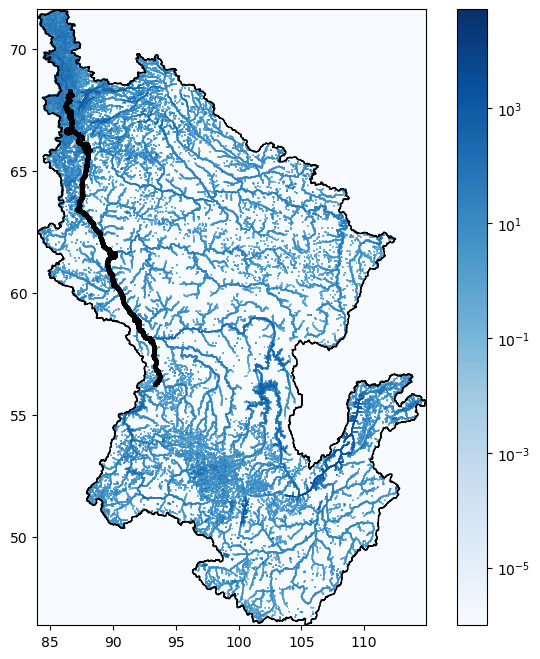

In [9]:
# Normalize the colormap based on percentiles
norm = Normalize(vmin=p1, vmax=p99)  # 2nd to 98th percentile
# Replace zeros with small non-zero value for log scale
data_log = np.where(data > 0, data, 1e-6)
norm_log = LogNorm()
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(data_log, cmap='Blues', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top], norm=norm_log)
# Raster Data
ax.scatter(water['lon_w'], water['lat'], c='black',marker='o', s=10, linewidth=1, edgecolor='none', zorder=9) 
# Vector Data
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1)
plt.colorbar(img, ax=ax)
plt.show()

In [10]:
# Statistics/Regression Models (SciPy)
import statsmodels.api as sm
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

In [11]:
def perform_regression_and_plot(dfc, x_variable, y_variable, y_limits=None):
    # Create a new dataframe for analysis
    df = pd.DataFrame()
    df[y_variable] = dfc[y_variable]
    df[x_variable] = dfc[x_variable]
    df.index = df[x_variable]
    df = df.dropna()

    # Preparing the data for statsmodels
    X = sm.add_constant(df[x_variable])  # adding a constant
    y = df[y_variable]

    # Fit the model
    model = sm.OLS(y, X).fit()
    df['model'] = model.predict(X)

    # Extracting coefficients and performance metrics
    a_opt, b_opt = model.params[x_variable], model.params['const']
    R2 = model.rsquared
    p_value = model.pvalues[x_variable]
    #print(model.summary())

    # Set Plot
    fig, ax = plt.subplots(figsize=(6,4))

    # Plot Observed Data with Color
    ax.scatter(dfc[x_variable], dfc[y_variable], c='white', edgecolor='blue', lw=1, s=50, zorder=1)
    # Plot Modeled Data
    ax.plot(df[x_variable], df['model'], c='black', lw=3, ls='--', zorder=3)

    # Labels and Axes
    ax.set_title(f'{y_variable} (n={df.shape[0]})', fontsize=18, c='black', pad=10)
    ax.set_ylabel('[m]', fontsize=14, color='black', labelpad=30, rotation=0)
    ax.set_xlabel('Latitude', fontsize=14, c='black', labelpad=15)

    if y_limits:
        ax.set_ylim(*y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=10)

    ax.text(0.22, 0.92, rf"R$^2$ = {R2:.2f}", fontsize=11, color='black', 
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.22, 0.85, f"p = {p_value:.6f}", fontsize=11, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.24, 0.78, f"y = {a_opt:.2f}x + {b_opt:.2f}", fontsize=11, color='black', 
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    ax.grid(color='black', alpha=0.05)
    #ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

    plt.show()

    return fig, ax

C:\Users\wbcho\anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


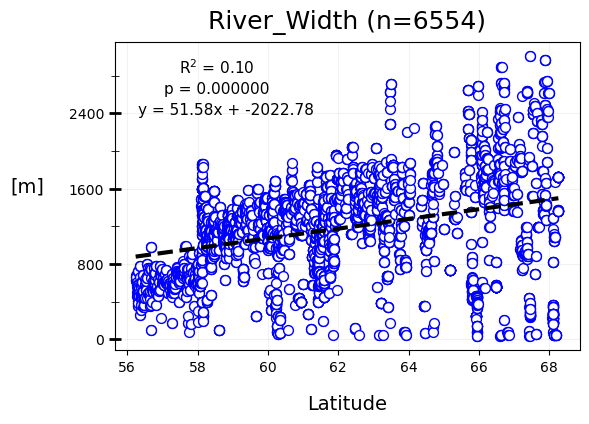

In [12]:
perform_regression_and_plot(combined_df, 'lat','River_Width', y_limits=None)


# Folder to Save Images
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')
fig.savefig('River_Width_OLS.png', dpi = 600, bbox_inches='tight')

In [13]:
#perform_regression_and_plot(combined_df_15T, 'lat','River_Width', y_limits=None)

In [14]:
#perform_regression_and_plot(combined_df_30T, 'lat','River_Width', y_limits=None)

In [15]:
#perform_regression_and_plot(combined_df_1H, 'lat','River_Width', y_limits=None)

C:\Users\wbcho\anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


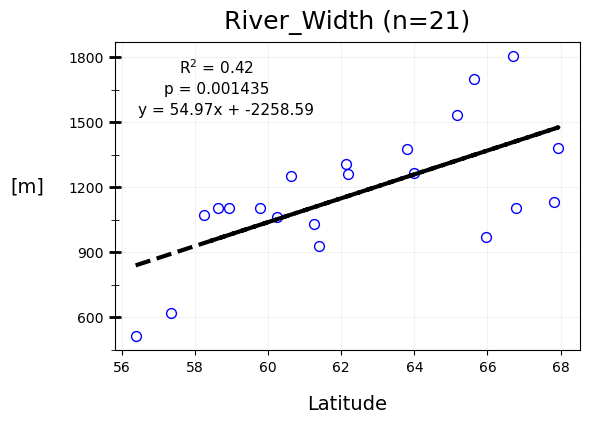

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'River_Width (n=21)'}, xlabel='Latitude', ylabel='[m]'>)

In [16]:
perform_regression_and_plot(combined_df_24H, 'lat','River_Width', y_limits=None)

<br><br><br>

# CLuStEr

##### Standardizing the Data: 
This is especially important if you're including multiple variables with different scales.

##### Finding Optimal Number of Clusters: 
Using the Elbow Method, and optionally the silhouette score, to determine a suitable number of clusters.

##### Applying K-means Clustering: 
Using the identified number of clusters.

##### Assigning Cluster Labels: 
Adding the cluster labels back to your original DataFrame.

##### Visualizing Clusters: 
Displaying a simple scatter plot to visualize the clusters (this is a 1-dimensional representation as we're only using river width).

<br><br>

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [18]:
# Original length
original_length = len(combined_df)

# Dropping missing values
data = combined_df[['River_Width', 'lat']].dropna() #.reset_index(drop=True)

# Length after dropping NA
length_after_dropping_na = len(data)
print(f"Original length: {original_length}, Length after dropping NA: {length_after_dropping_na}")


Original length: 15027, Length after dropping NA: 6554


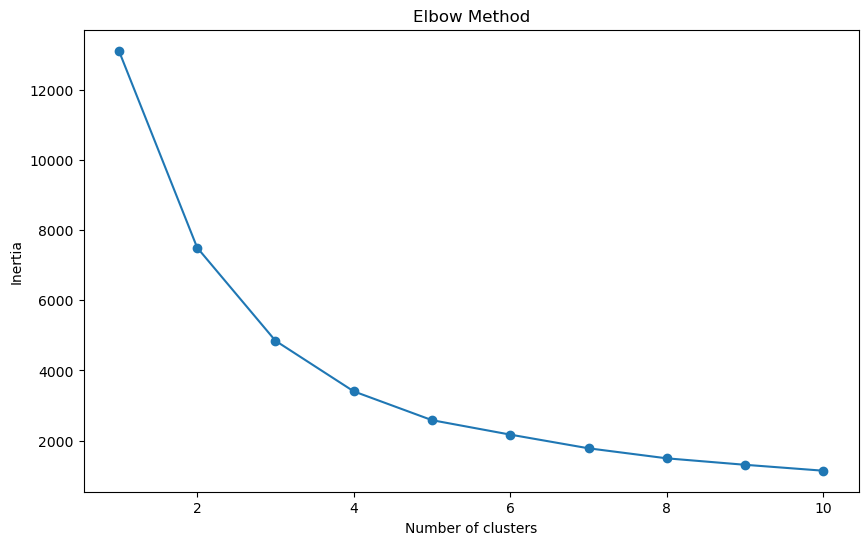

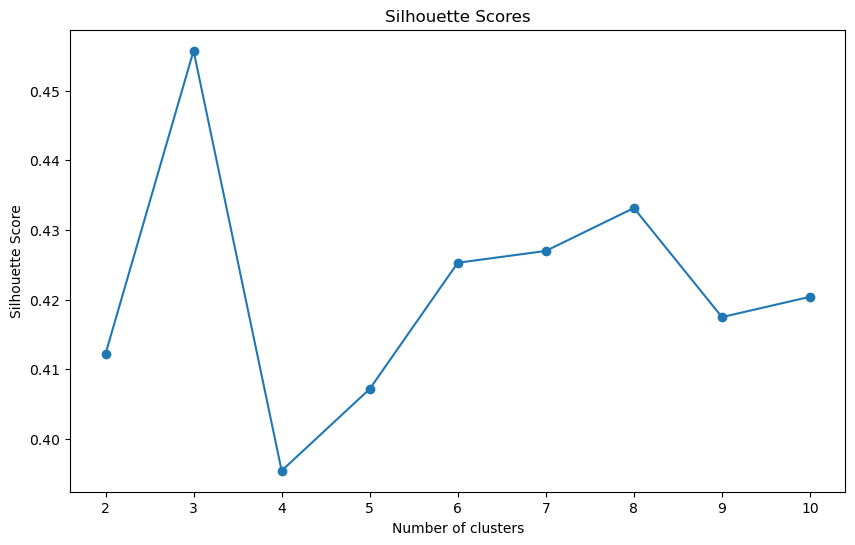

In [19]:
# Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Determining the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):  # testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette scores to further validate the number of clusters
silhouette_scores = []
for i in range(2, 11):  # silhouette score can't be computed with just 1 cluster
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_scaled)
    score = silhouette_score(data_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


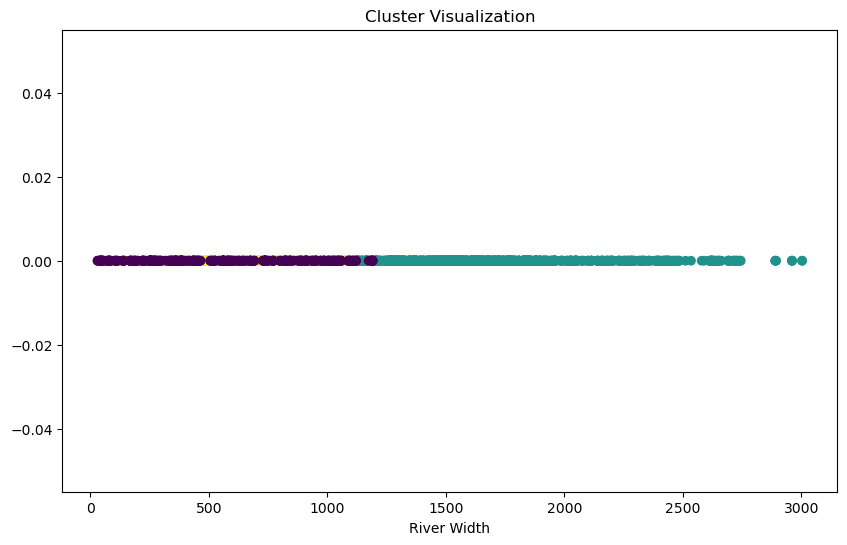

In [20]:
# Choose the number of clusters (k) based on the Elbow Method and silhouette scores
kmeans_optimal = KMeans(n_clusters=3, random_state=0)
kmeans_optimal.fit(data_scaled)
clusters = kmeans_optimal.labels_

# Add the cluster information to the original DataFrame
data['Cluster'] = clusters

# Visualizing the clusters (optional)
plt.figure(figsize=(10, 6))
plt.scatter(data['River_Width'], [0] * len(data), c=data['Cluster'], cmap='viridis')
plt.xlabel('River Width')
plt.title('Cluster Visualization')
plt.show()


In [21]:
data['Cluster'].unique()

array([2, 1, 0])

In [22]:
# Group data by clusters and calculate min and max for each cluster
cluster_ranges = data.groupby('Cluster')['River_Width'].agg(['min', 'max'])

# Sort the clusters by their min values (so they are ordered from smallest to largest)
cluster_ranges = cluster_ranges.sort_values('min')

# Rename clusters based on their size (small, medium, large)
cluster_names = {i: size for i, size in enumerate(['Small', 'Medium', 'Large'])}
data['Cluster_Size'] = data['Cluster'].map(cluster_names)

# Print cluster ranges
print(cluster_ranges)

                 min        max
Cluster                        
0          30.147300  1189.9016
2          55.909695  1861.9324
1        1098.365800  3003.7607


In [23]:
data['Cluster_Size'].unique()

array(['Large', 'Medium', 'Small'], dtype=object)

In [24]:
small_min, small_max = cluster_ranges.iloc[0]['min'], cluster_ranges.iloc[0]['max']
medium_min, medium_max = cluster_ranges.iloc[1]['min'], cluster_ranges.iloc[1]['max']
large_min, large_max = cluster_ranges.iloc[2]['min'], cluster_ranges.iloc[2]['max']

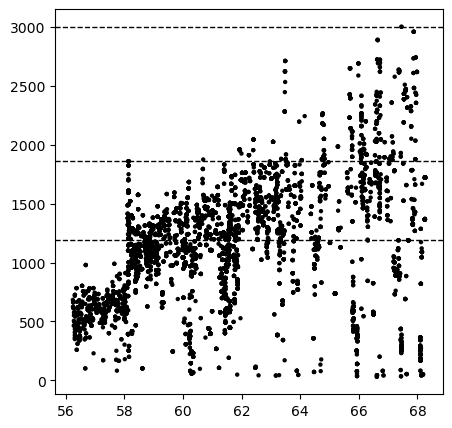

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))# Raster Data
ax.scatter(data['lat'], data['River_Width'], c='black',marker='o', s=10, linewidth=1, edgecolor='none', zorder=9) 
ax.axhline(small_max, lw=1, c='black', ls='--')
ax.axhline(medium_max, lw=1, c='black', ls='--')
ax.axhline(large_max, lw=1, c='black', ls='--')

In [26]:
data

,River_Width,lat,Cluster,Cluster_Size
0,683.58276,56.239426,2,Large
2,624.93170,56.244664,2,Large
3,624.93170,56.247253,2,Large
4,613.92944,56.249884,2,Large
5,663.19920,56.252675,2,Large
...,...,...,...,...
5692,1722.27580,68.259303,1,Medium
5693,1722.27580,68.259451,1,Medium
5694,1722.27580,68.259631,1,Medium
5695,1722.27580,68.259798,1,Medium
